<a href="https://colab.research.google.com/github/repoocsov/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



#**Assignment begins here:**

##**1)**

In [0]:
false_positive = 0.08
true_positive = 1.00
prior_belief = .001 # prior belief (1/1000)

def prob_drunk_given_positive(prior_belief, false_positive, true_positive):
  sober_driver = 1 - prior_belief
  posterior_probability = (true_positive * prior_belief) / ((true_positive * prior_belief) + (false_positive * sober_driver))
  return posterior_probability


# Probability that a person is drunk after one positive breathalyzer test
prob_drunk_given_positive(prior_belief, false_positive, true_positive)

0.012357884330202669

In [0]:
# Probability that a person is drunk after two positve breathalyzer tests
updated_prior_belief = prob_drunk_given_positive(prior_belief, false_positive, true_positive)
prob_drunk_given_positive(updated_prior_belief, false_positive, true_positive)

0.13525210993291495

In [0]:
prior_belief = 1/1000
confidence_level = 0
count = 0

while(confidence_level < .95):
  confidence_level = prob_drunk_given_positive(prior_belief, false_positive, true_positive)
  prior_belief = confidence_level
  count = count + 1

print(count, 'breathalyzer tests needed to be 95% confident')

4 breathalyzer tests needed to be 95% confident


##**2)**

In [0]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', header=None, na_values='?')

# Designating headers
headers = ['party', 'handicapped-infants', 'water-project', 
'budget', 'physician-fee-freeze', 'el-salvador-aid', 'religious-groups', 
'anti-satellite-ban', 'aid-to-contras', 'mx-missile', 'immigration', 
'synfuels', 'education', 'right-to-sue', 'crime', 'duty-free', 
'south-africa']
df.columns = headers

# Converting to numeric format
df = df.replace({'n': 0, 'y': 1})
df.head()

# Creating two seperate dataframes
condition = df['party'] == 'republican'
republicans = df[condition]

condition = df['party'] == 'democrat'
democrats = df[condition]
democrats.head(3)

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
# Expore scipy.stats.bayes_mvs here https://github.com/scipy/scipy/blob/master/scipy/stats/morestats.py
# Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
from scipy import stats
import numpy as np

"""------------------------------------"""
"""Using scipy.stats.bayes_mvs function"""
"""------------------------------------"""

# THIS IS THE FREQUENTIST APPROACH
def confidence_interval(data, confidence=0.95):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  s = np.std(data, ddof=1)
  stderr = s / np.sqrt(n)
  margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - margin_of_error, mean + margin_of_error)


rep_budget_no_nans = republicans['budget'].dropna(axis=0)
rep_budget_ci = confidence_interval(rep_budget_no_nans, confidence=0.95)
print("Frequentist Approach: ", rep_budget_ci)


# THIS IS THE BAYESIAN APPROACH
bayesian_confidence_interval, _, _ = stats.bayes_mvs(rep_budget_no_nans, alpha=.95)
print("Bayesian Approach", bayesian_confidence_interval)

Frequentist Approach:  (0.13414634146341464, 0.08143520131697565, 0.18685748160985363)
Bayesian Approach Mean(statistic=0.13414634146341464, minmax=(0.08143520131697565, 0.18685748160985363))


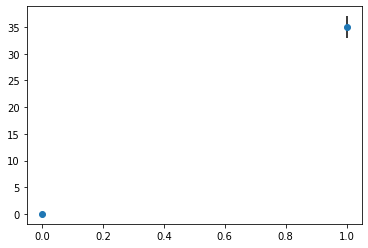

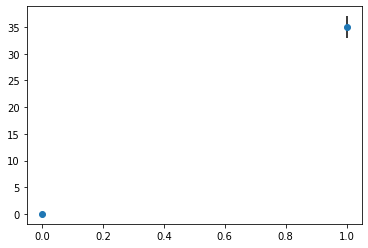

In [0]:
# Plotting with Matplotlib Error Bars
import matplotlib.pyplot as plt
import seaborn as sns

# confidence interval using Frequentist data
plt.errorbar(x=[0],y=rep_budget_ci[1], yerr=[(rep_budget_ci[2]-rep_budget_ci[0])], ecolor='black', fmt='o')
plt.errorbar(x=[1],y=[35], yerr=[2], ecolor='black', fmt='o');
plt.show()

# confidence interval using Bayesian data
plt.errorbar(x=[0],y=bayesian_confidence_interval[1][0], yerr=[(bayesian_confidence_interval[1][1]-bayesian_confidence_interval[0])], ecolor='black', fmt='o')
plt.errorbar(x=[1],y=[35], yerr=[2], ecolor='black', fmt='o');
plt.show()

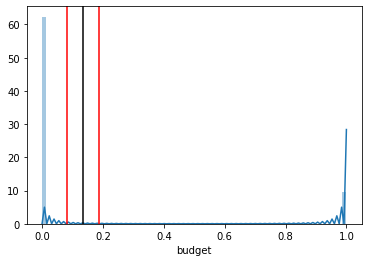

In [0]:
# Seaborn barplot with error bars
ax = sns.distplot(rep_budget_no_nans, bins=72)

plt.axvline(x=bayesian_confidence_interval[0], color='black')
plt.axvline(x=bayesian_confidence_interval[1][0], color='red')
plt.axvline(x=bayesian_confidence_interval[1][1], color='red');

##**3)**

Bayesian and frequentist statistics differ in the way they define the concept of probability. Frequentist statistics views probability as a likelihood in isolation. A measurement of probability in a sample and nothing more. With a Bayesian approach, these measurements of probability can be taken and used to be more accurate in predictions of probability.

https://www.probabilisticworld.com/frequentist-bayesian-approaches-inferential-statistics/

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!